In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import schwinger,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve

In [3]:
N=2
g=1
a=8
theta=np.pi
m=5
H,sx,sy,sz=schwinger(N=N,g=g,a=a,theta=theta,m=m)

In [4]:
H=H/20

In [5]:
Q=sx[-1]+1.1*sy[-1]+0.9*sz[-1] ## take a look at the berlin guys paper to see if this is a bad coupling operator

In [9]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
w0=0.5*a
gamma=w0/2
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)/3
lam

True


0.6559965570884768

In [10]:
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)
rho0=psi0*psi0.dag()
times=np.linspace(0,500,1000)
tfit=np.linspace(0, 50, 5000)

In [11]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-1.00e-02 |-3.51e+00 |1.19e-21                              | 1         |-5.56e-02 |-1.00e+00 |3.87e+00                              
 2         | 5.72e-02 |-1.02e+00 |3.86e+00                              |                                                                        
                                                                        |A  normalized RM

In [12]:
times2 = np.linspace(0,50,100)
cvis = bath.correlation_function(times2)

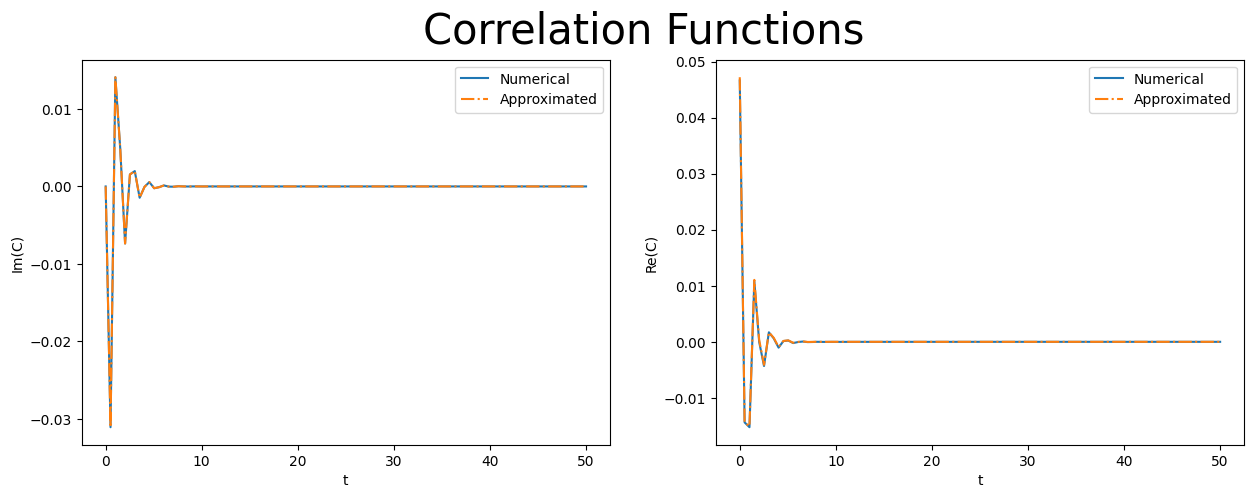

In [13]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [14]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=5, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.0%. Run time:   3.95s. Est. time left: 00:00:00:35
20.0%. Run time:   7.89s. Est. time left: 00:00:00:31
30.0%. Run time:  11.86s. Est. time left: 00:00:00:27
40.0%. Run time:  15.83s. Est. time left: 00:00:00:23
50.1%. Run time:  19.81s. Est. time left: 00:00:00:19
60.1%. Run time:  23.78s. Est. time left: 00:00:00:15
70.1%. Run time:  27.76s. Est. time left: 00:00:00:11
80.1%. Run time:  31.74s. Est. time left: 00:00:00:07
90.1%. Run time:  35.72s. Est. time left: 00:00:00:03
100.0%. Run time:  39.65s. Est. time left: 00:00:00:00
Total run time:  39.65s


In [15]:
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Calculating Integrals ...: 100%|█████████████| 25/25 [00:11<00:00,  2.09it/s]
Calculating time independent matrices...: 100%|█| 25/25 [00:00<00:00, 2686.31
Calculating time dependent generators: 100%|█| 25/25 [00:00<00:00, 124.35it/s
Computing Exponential of Generators . . . .: 100%|█| 1000/1000 [00:00<00:00, 


In [16]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-16}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-16})

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-2.25e-03 |-1.12e+00 |5.17e-15                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-6.34e-03 |-5.34e+00 |1.13e-14                              |                                                                        
                                                                        |A  normalized RM

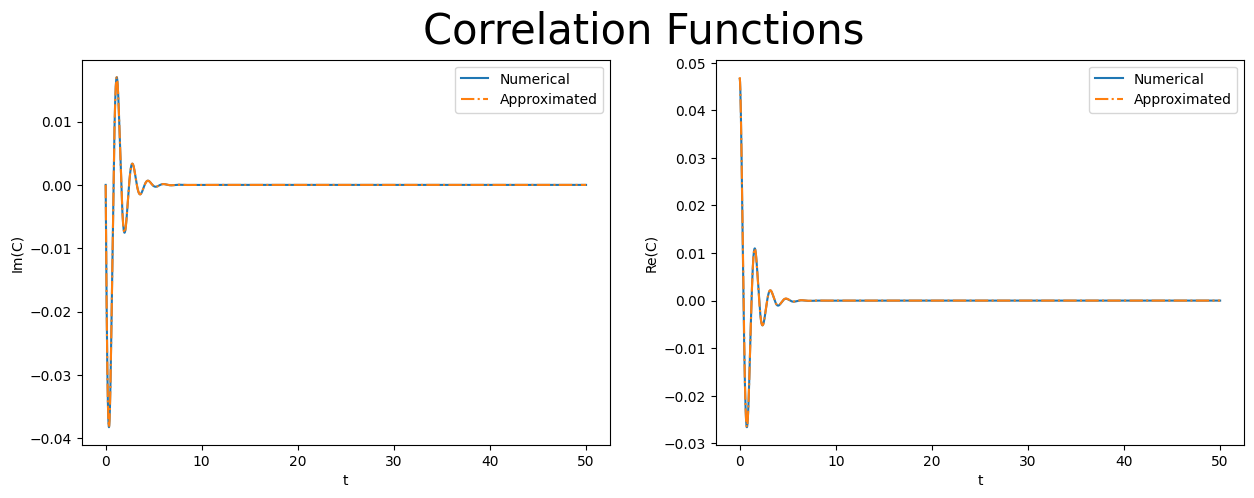

In [17]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)
print(bathu.finfo["summary"])
cvis2 = bathu.correlation_function
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(tfit, np.imag(cvis2),label="Numerical")
axs[0].plot(tfit, np.imag(bathu.bath.correlation_function_approx(tfit))+np.imag(bathu.C0(tfit, lam, gamma, w0)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(tfit, np.real(cvis2),label="Numerical")
axs[1].plot(tfit, np.real(bathu.bath.correlation_function_approx(tfit)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [18]:
# ans = example.evolution(rho0, Ncutoff, times, options={
#                         "atol": 1e-14, "normalize_output": False, "store_states": True})
# ans = [i.ptrace(range(N))for i in ans.states]

In [19]:
from nmm import redfield

In [20]:
bath.bose=None
red = redfield.redfield(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-8,matsubara=False)

result_red = red.evolution(rho0)


Started interpolation


In [21]:
result_red=[Qobj(i) for i in result_red]
for i in result_red:
    i.dims=H.dims
result_red = rotation(result_red, H, times)

In [30]:
global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4
c_ops2=[Qobj((np.sqrt(bath.power_spectrum(k))*v).data) for k, v in global_one.items()]
for i in range(len(c_ops2)):
    c_ops2[i].dims=H.dims 
result_lindblad_global= mesolve(H, rho0, times, c_ops2)

In [31]:
results=[result,result_cum,resultBR,resultBR2,result_red,result_lindblad_global]

In [32]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Redfield","Global"]
    style=["solid","solid","dashed","dashdot",'dashed','solid',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

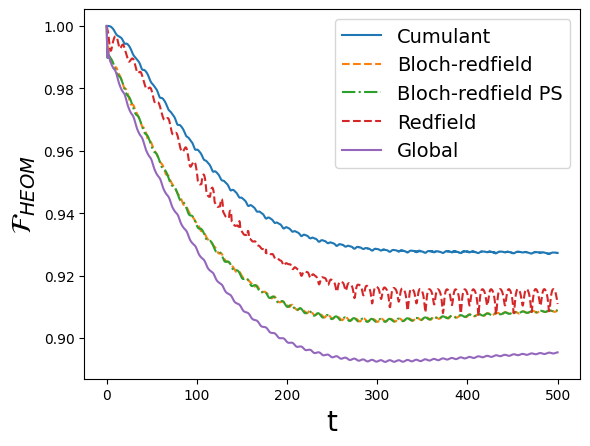

In [33]:
plot_fidelities(results,H,times)

In [25]:
result_red[498]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.82010585e-02+1.72914428e-19j  8.29033531e-04-9.42035017e-04j
   1.25186600e-03+1.56311177e-03j -3.56416634e-03+2.00472045e-02j]
 [ 8.29033531e-04+9.42035017e-04j  1.91018817e-01+1.04083409e-17j
  -3.67326457e-01-7.59493126e-02j -4.64366768e-04-6.67184404e-04j]
 [ 1.25186600e-03-1.56311177e-03j -3.67326457e-01+7.59493126e-02j
   7.42271400e-01-2.77555756e-17j -2.50638614e-03-5.25947442e-03j]
 [-3.56416634e-03-2.00472045e-02j -4.64366768e-04+6.67184404e-04j
  -2.50638614e-03+5.25947442e-03j  8.50872401e-03+4.66143360e-19j]]

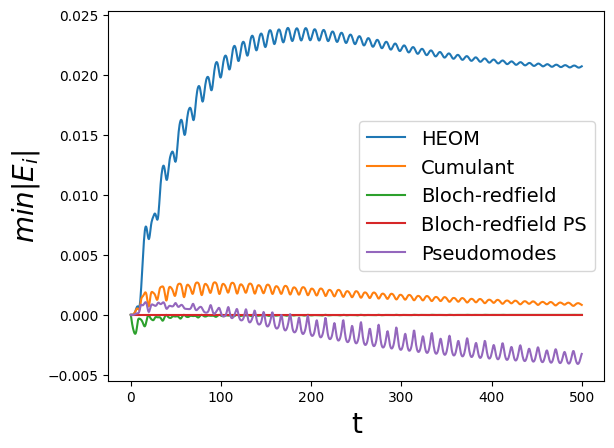

In [26]:
plot_positivity(results,H,times)

In [27]:
def plot_positivity(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes","Redfield"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([np.min(i.states[j].eigenenergies()) for j in range(len(times))])
        except:
            sdd=np.array([np.min(i[j].eigenenergies())  for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k])
   # plt.ylim(-1e-3,0.001)
    plt.legend(fontsize=14)
    plt.ylabel(r"$min |E_i|$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

/home/gerardo/miniconda3/envs/spinchain/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gerardo/miniconda3/envs/spinchain/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


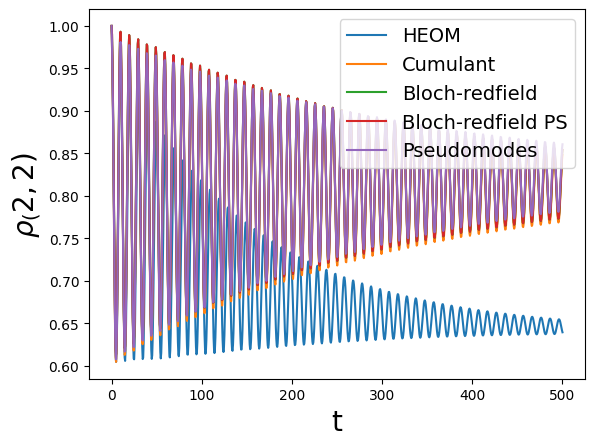

In [28]:
plot_populations(results,H,times,l=2,m=2)

In [29]:
from qutip import qsave

In [26]:
#qsave(results,f"N={N}_schwinger_{lam}_nocheating_seems_hard")